In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ancestrator import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


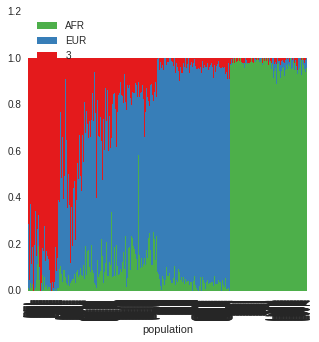

In [7]:
dataset = Dataset('1000Genomes', 'LEA', 'GAL_Completo')
admixture = dataset.admixture(Ks=range(2, 4+1), cores=4)
admixture.plot(3)

In [29]:
result = pd.read_table('/home/juan/tesina/1000Genomes/datasets/LEA.GAL_Completo.2.Q',
              sep='\s+', header=None)

result.columns = range(1, 2+1)
result.index = dataset.samplegroup.samples.index
result

,1,2
sample,,
HG00096,0.980340,0.019660
HG00097,0.999990,0.000010
HG00099,0.992223,0.007777
HG00100,0.979313,0.020687
HG00101,0.988965,0.011035
HG00102,0.999990,0.000010
HG00103,0.967565,0.032435
HG00105,0.977206,0.022794
HG00106,0.987668,0.012332
